In [ ]:
import scanpy as sc
import os 

from omegaconf import OmegaConf as om
from tahoe_x1.utils.util import compute_lisi_scores
from inference.predict_embeddings import predict_embeddings

/usr/lib/python3/dist-packages/megablocks/layers/weight_parallel.py:66: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd
/usr/lib/python3/dist-packages/megablocks/layers/weight_parallel.py:88: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_bwd
/usr/lib/python3/dist-packages/megablocks/layers/weight_parallel.py:130: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd
/usr/lib/python3/dist-packages/megablocks/layers/weight_parallel.py:172: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_bwd
/usr/lib/python3/dist-packages/megablo

In [ ]:
model_name = "Tx1-70m"
cfg = {
  "model_name": model_name,
  "paths": {
    "hf_repo_id": "tahoebio/TahoeX1",
    "hf_model_size": "70m",
    "adata_input":  "/tahoe/data/kim_test.h5ad",
  },
  "data": {
    "cell_type_key": "cell_type", #"", #"cell_line"  #"OncotreeLineage"
    "gene_id_key": "ensembl_id"  #"", "feature_id"
  },
  "predict": {
    "seq_len_dataset": 2048,  #8192
    "return_gene_embeddings": False,  # Whether to extract gene embeddings
    "use_chem_inf": False,  # Whether to use chemical information for prediction if the model is trained with chemical information
  },
  "plot":
  {
    "save_dir": "./figures"
  }
}

cfg = om.create(cfg)

In [3]:
cfg

{'model_name': 'Tx1-70m', 'paths': {'hf_repo_id': 'tahoebio/TahoeX1', 'hf_model_size': '70m', 'adata_input': '/tahoe/data/kim_test.h5ad'}, 'data': {'cell_type_key': 'cell_type', 'gene_id_key': 'ensembl_id'}, 'predict': {'seq_len_dataset': 2048, 'return_gene_embeddings': False, 'use_chem_inf': False}, 'plot': {'save_dir': './figures'}}

In [4]:
# Extract embeddings
adata = predict_embeddings(cfg)

Tx1-70m
Model is loaded with 12 transformer layers.
match 20349/20349 genes in vocabulary of size 62720.


/tahoe/umair/mosaicfm-release/scripts/inference/predict_embeddings.py:80: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["id_in_vocab"] = [
/usr/lib/python3/dist-packages/composer/trainer/trainer.py:1258: UserWarning: No optimizer was specified. Defaulting to DecoupledSGDW(lr=0.1)
  warnings.warn((
******************************
Config:
composer_commit_hash: None
composer_version: 0.28.0
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 1290244790

******************************
/tahoe/umair/mosaicfm-release/scripts/inference/predict_embeddings.py:172: ImplicitModificationWarning: Setting element `.obsm['Tx1-70m']` of view, initializing view as actual.
  adata.obsm[model_name] = cell_array


In [6]:
cell_array = adata.obsm[model_name]

LISI score: 4.2395


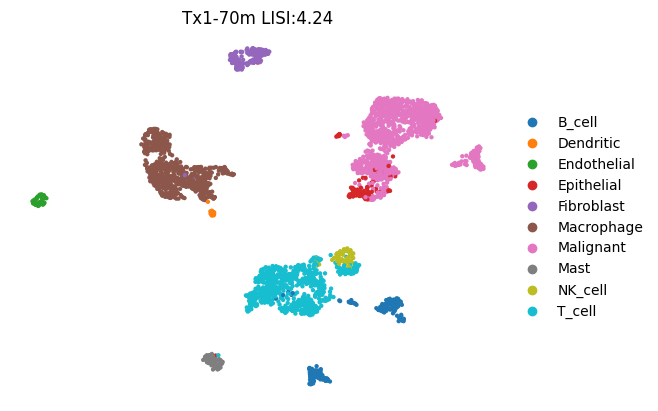

In [ ]:
# Calculate LISI
cell_type_key = cfg.data.cell_type_key
lisi_score = compute_lisi_scores(cell_array, 
                                adata.obs[cell_type_key].values, 
                                20) 
print(f"LISI score: {lisi_score:.4f}")


# Plotting
adata.obs[cell_type_key] = adata.obs[cell_type_key].astype('category')
sc.pp.neighbors(adata, use_rep=model_name)
sc.tl.umap(adata)
fig = sc.pl.umap(adata, 
           color=[cell_type_key], 
           frameon=False, 
           wspace=0.4, 
           title=[f"{model_name} LISI:{lisi_score:.2f}"],
           return_fig=True)

# Save figure
save_dir = cfg.plot.save_dir
os.makedirs(save_dir, exist_ok=True)
fig.savefig(f"{save_dir}/{model_name}_{cfg.paths.adata_input.split('/')[-1].replace('.h5ad','')}.png", dpi=300, bbox_inches="tight")

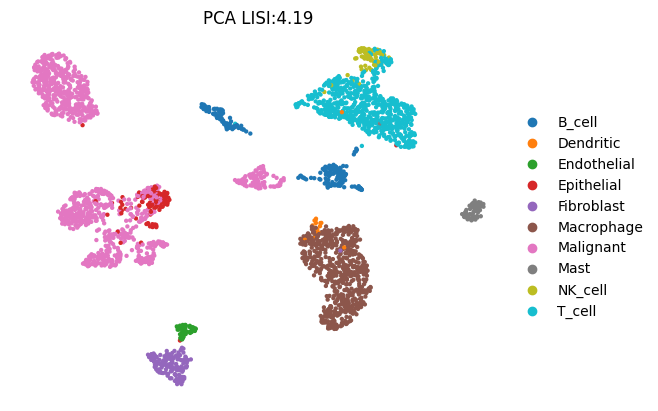

In [5]:
#PCA

sc.pp.normalize_total(adata, target_sum=10000, inplace=True)
sc.pp.log1p(adata)
sc.tl.pca(adata, n_comps=15)
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)

lisi_score = compute_lisi_scores(adata.obsm["X_pca"], adata.obs[cell_type_key], 20)
fig = sc.pl.umap(adata, color=cell_type_key, title=f"PCA LISI:{lisi_score:.2f}", return_fig=True, frameon=False,)

fig.savefig(f"{save_dir}/PCA_{cfg.paths.adata_input.split('/')[-1].replace('.h5ad','')}.png", dpi=300, bbox_inches="tight")
